In [5]:
import MDAnalysis as mda
from modules.distances import *
from modules.dssp import dssp
from modules.input import res_list, show_fasta
from typing import Tuple
import os
%reload_ext autoreload
%autoreload 2
import input
import subprocess

In [6]:
atomistic_system, reference_structure, energy_like_terms, is_aligned = input.read_files()
is_aligned = input.align_traj(is_aligned)

Aligned file found, reading this instead
Trajectory allready aligned, delete md1000ns_center_po_aligned.xtc to rerun alignement


In [7]:
pepsi_saxs_command = "/mnt/d/MD/Pepsi-SAXS"

In [8]:

tmp_path = f"{input.sim_path}\\tmp\\"

if tmp_path [0] != "/":
    path_wslified = f"/mnt/{tmp_path[0].lower()}/{tmp_path[3:]}".replace("\\", "/")
else:
    path_wslified = tmp_path




In [9]:
try:
    os.mkdir(tmp_path)
except:
    pass

protein = atomistic_system.select_atoms("protein")
protein.write(f"{tmp_path}pepsi_tmp.pdb", file_format="pdb")
pepsi_run = subprocess.run(f"wsl cd {path_wslified}; {pepsi_saxs_command} pepsi_tmp.pdb --dist", shell=True)

C:\Users\Clément\AppData\Roaming\Python\Python310\site-packages\MDAnalysis\coordinates\PDB.py:1129: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"
C:\Users\Clément\AppData\Roaming\Python\Python310\site-packages\MDAnalysis\coordinates\PDB.py:1176: UserWarning: Found missing chainIDs. Corresponding atoms will use value of 'X'
  warnings.warn("Found missing chainIDs."


In [51]:
import csv
with open(f"{tmp_path}pepsi_tmp.out") as f:
    pepsi_data =[]
    for i, line in enumerate(f):
        if i < 6:
            pass
        else:
            f_line = []
            values = line.rstrip().split()
            for value in values:
                 f_line.append(float(value))
            pepsi_data.append(f_line)
pepsi_data = np.array(pepsi_data)
print(pepsi_data.T[1])
            

[1.55266534e-02 1.53046886e-02 1.50025267e-02 1.45399706e-02
 1.38597595e-02 1.30051127e-02 1.20467578e-02 1.10498879e-02
 1.00531308e-02 9.08715378e-03 8.18050639e-03 7.35060244e-03
 6.61120672e-03 5.97330037e-03 5.43180942e-03 4.97591214e-03
 4.59435125e-03 4.27315432e-03 3.99728819e-03 3.75239418e-03
 3.52883459e-03 3.31898208e-03 3.11585051e-03 2.91732432e-03
 2.72354620e-03 2.53479726e-03 2.35242829e-03 2.17832955e-03
 2.01428071e-03 1.86098384e-03 1.71855051e-03 1.58702363e-03
 1.46579253e-03 1.35385776e-03 1.25023585e-03 1.15418869e-03
 1.06513650e-03 9.82521837e-04 9.06043589e-04 8.35579899e-04
 7.71003339e-04 7.12051385e-04 6.58359157e-04 6.09549593e-04
 5.65086566e-04 5.24303449e-04 4.86535662e-04 4.51229329e-04
 4.17928889e-04 3.86192300e-04 3.55794059e-04 3.26716815e-04
 2.98954618e-04 2.72575290e-04 2.47723397e-04 2.24544864e-04
 2.03121794e-04 1.83464423e-04 1.65577574e-04 1.49412488e-04
 1.34855108e-04 1.21787692e-04 1.10103696e-04 9.97113484e-05
 9.05203047e-05 8.246039

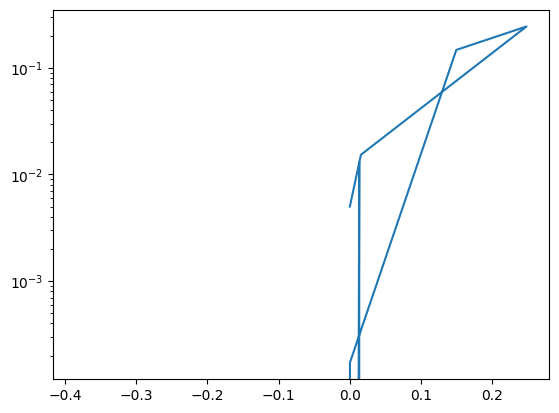

In [55]:
fig, ax = plt.subplots()
ax.set_yscale("log")
#ax.set_xscale("log")
ax.plot(pepsi_data[0], pepsi_data[1])

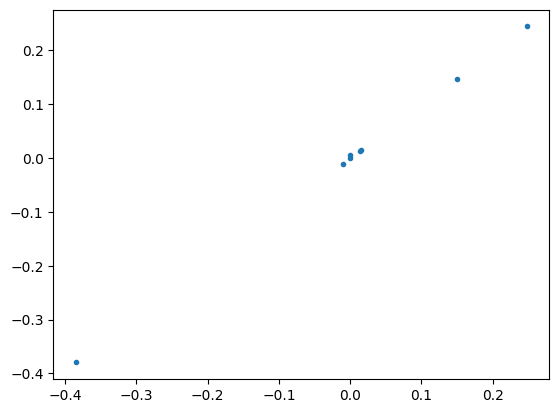

[0.624153094, 0.03, 0.03, 2.0, -0.379648023]
found :  [42.46953213973477, 5.443055464179346, 7.21874413063729, 0.18965760641774185, -38.99325375926802]


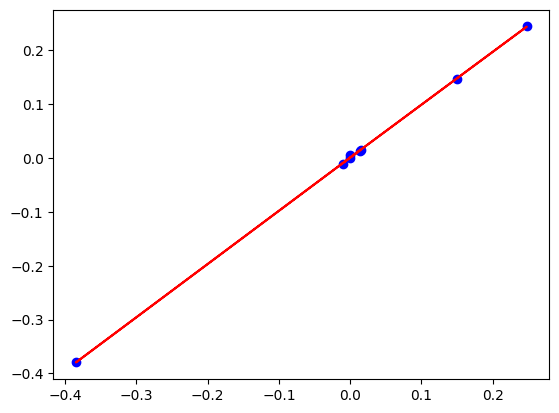

In [41]:
'''
example of use for open a data file (rgr) , plot, and fit
by a model
'''
import numpy
import pySAXS
import os
from matplotlib import pylab as plt
#get the filename
p=os.path.dirname(pySAXS.__file__)
dataFile="sample-lupolen-1800s.rgr"
completeDataFile=p+os.sep+"saxsdata"+os.sep+dataFile
#open data
completeData=numpy.loadtxt(completeDataFile)
data=completeData.transpose()

#----- plot data in matplotlib
datax=pepsi_data[0]
datay=pepsi_data[1]
plt.plot(datax,datay,linestyle='none',marker='.')
plt.show()

#----- Now we want to fit with pearsonVII
'''
par[0] : Amplitute of peak
par[1] : q at maximum of peak
par[2] : width of peak
par[3] : shape of peak
par[4] : background
'''
#best is to find some inital values
#1- background
background=datay.min()
#2- amplitude
amplitude=datay.max()-background
#3- q
qAtMax=0.03
width=0.03
#----- fit
from pySAXS.models import PearsonVII
d=PearsonVII() #declare model
d.q=datax       #q data to model
d.Arg=[amplitude,qAtMax,width,2.0,background] #initial parameters
print(d.Arg)
res=d.fit(datay) #FIT !!!
print("found : ",res)
#----- plot result
d.Arg=res
i=d.getIntensity()
plt.plot(datax,datay,color='blue',linestyle='none',marker='o')
plt.plot(datax,i,color='red')
plt.show()



ValueError: x and y must have same first dimension, but have shapes (100,) and (198,)

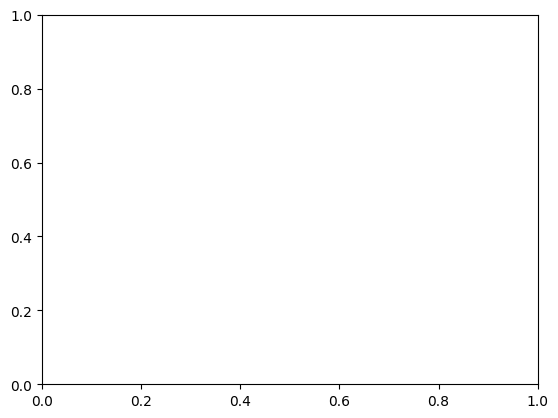

In [2]:
import numpy as np
from scipy.fft import irfft
from matplotlib import pylab as plt

def calculate_pr_from_iq(q, I):
  """
  Calculates the pair-distance distribution function (p(r)) from intensity (I(q)) data.

  Args:
      q (numpy.ndarray): Array of scattering vector (q) values.
      I (numpy.ndarray): Array of corresponding intensity values.

  Returns:
      numpy.ndarray: Array of p(r) values.
  """
  # Pre-factor for the FT
  prefactor = 2 * np.pi * q.max() 
  
  # Perform indirect FT using irfft (normalized by sample size)
  pr = irfft(I) * prefactor / len(q)
  
  # Adjust for zero padding at q=0 (optional)
  # pr[0] = 0  # Implement if needed for your analysis
  
  return pr

# Example usage (replace with your actual data)
q = np.linspace(0.1, 5.0, 100)  # Example q values
I = np.random.rand(100)        # Example intensity data

# Calculate p(r)
pr = calculate_pr_from_iq(q, I)

plt.plot(1/I,pr,linestyle='none',marker='.')
# Further processing and analysis of pr can be done here